In [137]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.io.json import json_normalize


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint

from nltk.tokenize import RegexpTokenizer


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [138]:
# Opening JSON file 
f = open('complaints.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=json_normalize(data)

## Data preparation

In [139]:
# Inspect the dataframe to understand the given data.

df

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


In [140]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [141]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
                   '_source.zip_code':'zip_code',
                  '_source.complaint_id':'complaint_id',
                  '_source.issue':'issue',
                  '_source.date_received':'date_received',
                  '_source.state':'state',
                  '_source.consumer_disputed':'consumer_disputed',
                  '_source.product':'product',
                  '_source.company_response':'company_response',
                  '_source.company':'company',
                  '_source.submitted_via':'submitted_via',
                  '_source.date_sent_to_company':'date_sent_to_company',
                  '_source.company_public_response':'company_public_response',
                  '_source.sub_product':'sub_product',
                  '_source.timely':'timely',
                  '_source.complaint_what_happened':'complaint_original',
                  '_source.sub_issue':'sub_issue',
                  '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [142]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_original']==''] = np.nan

In [143]:
#Remove all rows where complaints column is nan
df=df.dropna(subset=['complaint_original'])
df.reset_index(drop=True)

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_original,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided
21068,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
21069,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
21070,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.

In [144]:
# # Write your function here to clean the text and remove all the unnecessary elements.
from tqdm.notebook import tqdm
tqdm.pandas()

df['complaint_clean'] = df['complaint_original'].str.lower()
df['complaint_clean'] = df['complaint_clean'].replace(regex=[r'\{(.*?)\}',r'\((.*?)\)',r'\w*\d\w*'], value="")

punctuation = list(set(string.punctuation))


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

def process(text):
    text = whitespace_tokenizer(text)
    text = [w for w in text if w not in punctuation]
    return text

df['complaint_clean'] = df['complaint_clean'].progress_apply(process)

C:\Users\Sathappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Sathappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



  0%|          | 0/21072 [00:00<?, ?it/s]

C:\Users\Sathappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [145]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemetize(texts,allowed_postags=['NOUN']):
    doc = nlp(" ".join(texts))
    return ' '.join([token.lemma_ for token in doc if token.pos_ in allowed_postags])

df['complaint_clean'] = df['complaint_clean'].progress_apply(lemetize)

  0%|          | 0/21072 [00:00<?, ?it/s]

C:\Users\Sathappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [168]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_clean","complaint_original"]]

In [170]:
df_clean = df_clean.reset_index(drop=True)
df_clean

,complaint_clean,complaint_original
0,morning name xxxx xxxx stop bank cardmember se...,Good morning my name is XXXX XXXX and I apprec...
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...
3,xxxx ticket offer ticket reward card informati...,"On XX/XX/2018, while trying to book a XXXX XX..."
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...
...,...,...
21067,card customer decade solicitation credit card ...,After being a Chase Card customer for well ove...
21068,credit card provider claim purchase protection...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
21069,pay risk consumer chase chase year banking mer...,I am not familiar with XXXX pay and did not un...
21070,credit chase credit card freedom xxxx problem ...,I have had flawless credit for 30 yrs. I've ha...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

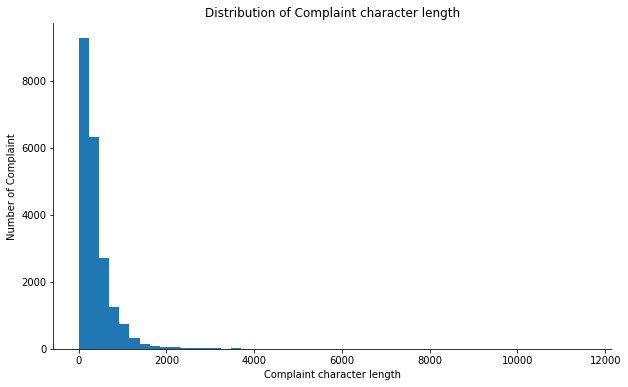

In [171]:
# Write your code here to visualise the data according to the 'Complaint' character length
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_clean]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

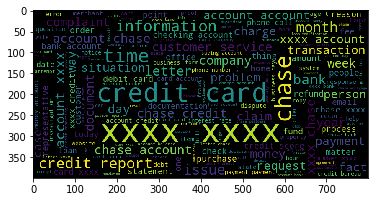

In [172]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

complaint_list = df_clean['complaint_clean'].tolist()
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)
complain_text = ' '.join([s for s in complaint_list])
wordcloud.generate(complain_text)
plt.imshow(wordcloud)
plt.show()

In [173]:
# Top 40 words
print(list(wordcloud.words_.keys())[:40])

['xxxx xxxx', 'credit card', 'chase', 'time', 'information', 'credit report', 'issue', 'month', 'bank', 'letter', 'account xxxx', 'customer service', 'xxxx chase', 'company', 'year', 'chase credit', 'account chase', 'chase account', 'day', 'week', 'document', 'money', 'payment', 'account account', 'person', 'charge', 'complaint', 'way', 'xxxx account', 'case', 'request', 'problem', 'fact', 'transaction', 'situation', 'claim', 'checking account', 'bank account', 'amount', 'chase xxxx']


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [174]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['complaint_clean'].values.astype('U'), 50)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [177]:
#Print the top 10 words in the unigram frequency
df2.head(10)

,unigram,count
0,xxxx,88283
1,chase,48436
2,account,46565
3,credit,32222
4,card,29450
5,payment,20968
6,bank,16846
7,time,15932
8,day,12861
9,charge,11974


In [178]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [179]:
#Print the top 10 words in the bigram frequency
df3.head(10)

,bigram,count
0,xxxx xxxx,24111
1,credit card,12658
2,credit report,3820
3,account xxxx,3353
4,customer service,3054
5,xxxx chase,2977
6,chase credit,2966
7,account chase,2909
8,chase account,2898
9,account account,2625


In [180]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['complaint_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the Complaint text"))
fig.show()

In [181]:
#Print the top 10 words in the bigram frequency
df4.head(10)

,trigram,count
0,xxxx xxxx xxxx,6584
1,chase credit card,2037
2,credit card account,990
3,credit card company,986
4,account xxxx xxxx,793
5,credit card xxxx,758
6,xxxx xxxx chase,745
7,xxxx credit card,712
8,credit card chase,627
9,credit card credit,567


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [182]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].replace(regex=r'x{2,}', value="")

In [183]:
#All masked texts has been removed
df_clean.head(10)


,complaint_clean,complaint_original
0,morning name stop bank cardmember service de...,Good morning my name is XXXX XXXX and I apprec...
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX..."
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...
5,inquiry,Can you please remove inquiry
6,account debit card branch customer service rep...,With out notice J.P. Morgan Chase restricted m...
7,summer month experience decline income employm...,"During the summer months, I experience a decli..."
8,payment retailer pay chase website scam websi...,"On XXXX XX/XX/2019, I made a {$300.00} payment..."
9,chase credit card datum credit report company ...,I have a Chase credit card which is incorrectl...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [184]:
#Write your code here to initialise the TfidfVectorizer 
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)

In [185]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(complaint_list)

In [186]:
print(tfidf)

  (0, 2731)	0.21035904644077424
  (0, 80119)	0.20462284312692863
  (0, 16443)	0.21999104249758877
  (0, 20838)	0.17205426115899464
  (0, 41497)	0.1696371212981596
  (0, 25773)	0.18951300107597854
  (0, 52630)	0.20594140583470605
  (0, 48712)	0.20103007554623795
  (0, 25800)	0.2533908486550907
  (0, 8029)	0.1925407714752028
  (0, 77224)	0.1759566376737834
  (0, 85059)	0.2533908486550907
  (0, 25922)	0.22514955100712142
  (0, 74568)	0.2224411180925001
  (0, 13376)	0.1786182892526003
  (0, 89420)	0.20594140583470605
  (0, 89657)	0.05005111754695475
  (0, 54108)	0.113935255677164
  (0, 53097)	0.22514955100712142
  (0, 38249)	0.09795532702570404
  (0, 2694)	0.12793689436437627
  (0, 80116)	0.12648202706366338
  (0, 15348)	0.03598096452324789
  (0, 20788)	0.08785873840510441
  (0, 41374)	0.06289796939006403
  :	:
  (21071, 1094)	0.219272167320709
  (21071, 42340)	0.1113822433609326
  (21071, 88978)	0.1443410468732588
  (21071, 65046)	0.09130566672251746
  (21071, 29569)	0.09491640026292003
 

## Topic Modelling using NMF
Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

Find the best number of clusters
Apply the best number to create word clusters
Inspect & validate the correction of each cluster wrt the complaints
Correct the labels if needed
Map the clusters to topics/cluster names

In [187]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [188]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model =  NMF(
    n_components=num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=40
)

In [189]:
W = nmf_model.fit_transform(tfidf) # Document - topic matrix
H = nmf_model.components_ # Topic - Term matrix

feature_names = tfidf_vectorizer.get_feature_names()

C:\Users\Sathappan\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1425: FutureWarning:

`alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead

C:\Users\Sathappan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [190]:
#Print the Top15 words for each of the topics
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 

def topic_table(cmp, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(cmp):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

topic_df = topic_table(
    H,
    feature_names,
    15
)

topic_df.head(15)

,0,1,2,3,4
0,xxxx,card,account,payment,inquiry
1,xxxx xxxx,credit,check,loan,report
2,charge,credit card,bank,mortgage,credit report
3,chase,chase,money,chase,credit
4,number,charge,fund,interest,inquiry credit
5,dispute,chase credit,chase,modification,report xxxx
6,letter,balance,deposit,month,report credit
7,claim,card credit,branch,home,reporting
8,transaction,purchase,day,year,card inquiry
9,email,account,fee,time,credit reporting


In [191]:
#Assign the best topic to each of the cmplaints in Topic Column
final = pd.DataFrame(W, columns=[i for i in range(num_topics)])

final['Topic_ind'] = final.apply(lambda x: x.idxmax(), axis=1)
final

,0,1,2,3,4,Topic_ind
0,0.020533,0.002690,0.008156,0.006973,0.004917,0
1,0.029584,0.005884,0.004890,0.000000,0.000460,0
2,0.000000,0.020639,0.000000,0.000000,0.009822,1
3,0.004388,0.022522,0.017360,0.003665,0.035824,4
4,0.006588,0.000000,0.069894,0.000000,0.000000,2
...,...,...,...,...,...,...
21067,0.000000,0.063942,0.003936,0.010910,0.000000,1
21068,0.010969,0.020014,0.012368,0.002323,0.000244,1
21069,0.009755,0.007650,0.015999,0.003430,0.013408,2
21070,0.000000,0.057603,0.000503,0.062141,0.000000,3


In [192]:
df_clean['Topic_ind'] = final['Topic_ind']
df_clean.head(5)


,complaint_clean,complaint_original,Topic_ind
0,morning name stop bank cardmember service de...,Good morning my name is XXXX XXXX and I apprec...,0
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,0
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...,1
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX...",4
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...,2


In [193]:
#Print the first 5 Complaint for each of the Topics
df_clean_grp=df_clean.groupby('Topic_ind').head(5)
df_clean_grp.sort_values('Topic_ind')

,complaint_clean,complaint_original,Topic_ind
0,morning name stop bank cardmember service de...,Good morning my name is XXXX XXXX and I apprec...,0
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,0
20,question information reason information chas...,"JP Morgan Chase Bank, please answer the follow...",0
19,purchase amount transaction dispute case ch...,I made a purchase with XXXX XXXX XXXX on XX/XX...,0
8,payment retailer pay chase website scam websi...,"On XXXX XX/XX/2019, I made a {$300.00} payment...",0
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...,1
25,chase reward point chase reward page request t...,I currently have over XXXX Chase Ultimate Rewa...,1
21,citizen company time share company refund cre...,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,1
16,sofa love seat table chair debit card visa cla...,"XXXX XXXX a sofa, love seat, table and chairs ...",1
14,chase amazon card catering order brother funer...,My chase amazon card was declined for a cateri...,1


### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
#### Bank Account services
#### Credit card or prepaid card
#### Theft/Dispute Reporting
#### Mortgage/Loan
#### Others

In [194]:
topic_mapping = {
    0 : "Bank Account services",
    1 : "Credit card or prepaid card",
    2 : "Mortgage/Loan",
    3 : "Others",
    4 : "Theft/Dispute Reporting"
}
df_clean['Topic'] = df_clean['Topic_ind'].map(topic_mapping)

In [195]:
df_clean.head()

,complaint_clean,complaint_original,Topic_ind,Topic
0,morning name stop bank cardmember service de...,Good morning my name is XXXX XXXX and I apprec...,0,Bank Account services
1,card agent anniversary date agent information ...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,0,Bank Account services
2,card application identity consent service cred...,Chase Card was reported on XX/XX/2019. However...,1,Credit card or prepaid card
3,ticket offer ticket reward card information o...,"On XX/XX/2018, while trying to book a XXXX XX...",4,Theft/Dispute Reporting
4,son check deposit chase account fund chase acc...,my grand son give me check for {$1600.00} i de...,2,Mortgage/Loan


### Supervised model to predict any new complaints to the relevant Topics.
You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [196]:
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_original', 'sub_issue', 'consumer_consent_provided',
       'complaint_clean'],
      dtype='object')

In [197]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_original','Topic_ind']]

In [198]:
training_data.head(5)

,complaint_original,Topic_ind
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,0
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",4
4,my grand son give me check for {$1600.00} i de...,2


In [199]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

### Apply the supervised models on the training data created. In this process, you have to do the following:
#### Create the vector counts using Count Vectoriser
#### Transform the word vecotr to tf-idf
#### Create the train & test data using the train_test_split on the tf-idf & topics

In [200]:
#Write your code to get the Vector count
#Write your code here to transform the word vector to tf-idf
X = training_data.complaint_original.values
y = training_data.Topic_ind.values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=70)

vectoriser = CountVectorizer()
tfIdfTransformer = TfidfTransformer(use_idf=True)

X_train = vectoriser.fit_transform(X_train)
X_train = tfIdfTransformer.fit_transform(X_train).toarray()

X_test = vectoriser.transform(X_test)
X_test = tfIdfTransformer.transform(X_test).toarray()

In [201]:
y_train

array([0, 1, 0, ..., 1, 0, 2], dtype=int64)

In [202]:
# Distribution of topics in dataset
training_data.Topic_ind.value_counts()

2    6163
1    4720
3    4491
0    3904
4    1794
Name: Topic_ind, dtype: int64

## You have to try atleast 3 models on the train & test data from these options:

Logistic regression

Decision Tree

Random Forest

Naive Bayes (optional)

Using the required evaluation metrics judge the tried models and select the ones performing the best

### Logistic Regression

In [203]:
# Write your code here to build any 3 models and evaluate them using the required metrics
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs' , penalty = 'l2')

lr.fit(X_train,y_train)

C:\Users\Sathappan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(multi_class='multinomial')

In [204]:
y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC on train : {accuracy_score(y_train,y_pred_train)}')
print(F'ACC on test : {accuracy_score(y_test,y_pred)}')
print(clf_report)


ACC on train : 0.9380079492199086
ACC on test : 0.873546856465006
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       827
           1       0.88      0.88      0.88       911
           2       0.90      0.92      0.91      1223
           3       0.91      0.93      0.92       909
           4       0.90      0.83      0.86       345

    accuracy                           0.87      4215
   macro avg       0.87      0.86      0.87      4215
weighted avg       0.87      0.87      0.87      4215



### Decision Tree Classifier

In [205]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=72)
dt.fit(X_train,y_train)
y_pred_train = dt.predict(X_train)
y_pred = dt.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC n train: {accuracy_score(y_train,y_pred_train)}')
print(F'ACC n test: {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC n train: 1.0
ACC n test: 0.7340450771055753
              precision    recall  f1-score   support

           0       0.61      0.60      0.60       827
           1       0.75      0.77      0.76       911
           2       0.78      0.77      0.78      1223
           3       0.77      0.78      0.78       909
           4       0.72      0.72      0.72       345

    accuracy                           0.73      4215
   macro avg       0.73      0.73      0.73      4215
weighted avg       0.73      0.73      0.73      4215



### Random Forest Classifier

In [206]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 50)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [207]:
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC n train: {accuracy_score(y_train,y_pred_train)}')
print(F'ACC n test: {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC n train: 1.0
ACC n test: 0.7551601423487544
              precision    recall  f1-score   support

           0       0.71      0.43      0.54       827
           1       0.72      0.80      0.76       911
           2       0.75      0.90      0.81      1223
           3       0.80      0.84      0.82       909
           4       0.86      0.69      0.76       345

    accuracy                           0.76      4215
   macro avg       0.77      0.73      0.74      4215
weighted avg       0.75      0.76      0.74      4215



### Logistic Regression seems to be best fit model among the three